In [126]:
#Настройка предупреждений
import warnings
warnings.simplefilter('ignore')

#Отображение графиков в самом jupyter
%pylab inline

#Увеличиваем дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [127]:
df = pd.read_csv('D:\DataMiningSets\stat.csv',sep=';')
df.shape

(47774, 4)

In [128]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47774 entries, 0 to 47773
Data columns (total 4 columns):
id                    47774 non-null object
category_path         47774 non-null object
expected_img_count    47774 non-null int64
real_img_count        47774 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


,id,category_path,expected_img_count,real_img_count
0,2081584,A\A21\A21B\A21B1\A21B122,2,0
1,2120757,A\A21\A21B\A21B1\A21B122,2,1
2,2275026,A\A21\A21B\A21B1\A21B122,4,1
3,2068641,A\A21\A21B\A21B1\A21B122,2,0
4,2133093,A\A21\A21B\A21B1\A21B122,4,2


### Ожидаемое  и  собранное число изображений

In [129]:
df[['expected_img_count','real_img_count']].sum()

expected_img_count    345367
real_img_count        212591
dtype: int64

### Получение разницы между ожидаемым и реальным числом собранных изображений

In [130]:
df['count_diff'] = [row['expected_img_count'] - row['real_img_count'] for index, row  in df.iterrows()]

### Выделение основных и уникальнах категории на основе структуры пути

In [131]:
#df['category'] = [full_path.rsplit('\\')[-1] for full_path in df['category_path']]
#print(len(df.groupby('category').count()))

df['main_category'] = [full_path.rsplit('\\')[0] for full_path in df['category_path']]
print(len(df.groupby('main_category').count()))

8


### Распределение числа патентов по основным категориям
* A — УДОВЛЕТВОРЕНИЕ ЖИЗНЕННЫХ ПОТРЕБНОСТЕЙ ЧЕЛОВЕКА
* B — РАЗЛИЧНЫЕ ТЕХНОЛОГИЧЕСКИЕ ПРОЦЕССЫ; ТРАНСПОРТИРОВАНИЕ
* C — ХИМИЯ; МЕТАЛЛУРГИЯ
* D — ТЕКСТИЛЬ; БУМАГА
* E — СТРОИТЕЛЬСТВО; ГОРНОЕ ДЕЛО
* F — МАШИНОСТРОЕНИЕ; ОСВЕЩЕНИЕ; ОТОПЛЕНИЕ; ДВИГАТЕЛИ И НАСОСЫ; ОРУЖИЕ И БОЕПРИПАСЫ; ВЗРЫВНЫЕ РАБОТЫ
* G — ФИЗИКА
* H — ЭЛЕКТРИЧЕСТВО


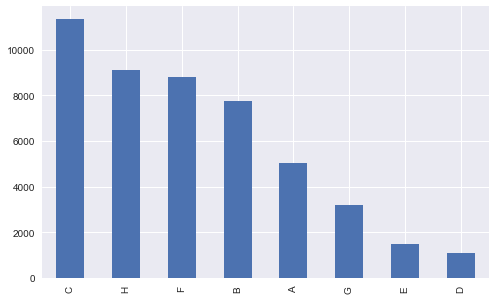

In [132]:
df['main_category'].value_counts().plot.bar()

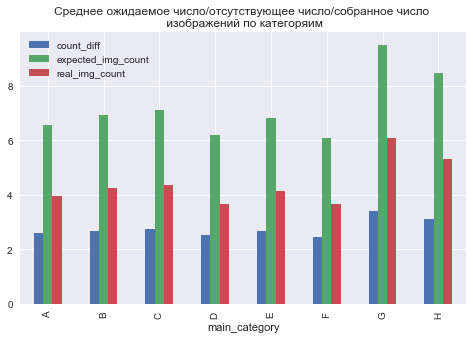

In [133]:
df.groupby('main_category')['count_diff','expected_img_count','real_img_count'].mean().plot.bar(
    title='Среднее ожидаемое число/отсутствующее число/собранное число \n изображений по категоряим')

### Сумарное число ожидаемого кол-ва изображений/ отсутсвующего кол-ва/ собранного  кол-ва изображений по категориям

In [134]:
df.pivot_table(values=['count_diff','expected_img_count','real_img_count'],index=['main_category'], aggfunc=np.sum)

,count_diff,expected_img_count,real_img_count
main_category,,,
A,13029,32948,19919
B,20899,53911,33012
C,31118,80524,49406
D,2774,6823,4049
E,3981,10134,6153
F,21543,53689,32146
G,10935,30338,19403
H,28497,77000,48503


### Полное разбиение на  категории


#### Максимальная и минимальная длина пути 

In [135]:
from operator import methodcaller
depths = df['category_path'].map(methodcaller("split", "\\")).map(len)

In [136]:
max_depth = depths.max()
min_depth = depths.min()
print(max_depth, min_depth)

5 3


In [137]:
# Подготовка  колонок для пути
for i in range(max_depth):
    df['level'+str(i)] = None

#### Вариации длин пути

In [138]:
df['category_path'].str.split('\\').map(len).value_counts()

5    44826
4     2947
3        1
Name: category_path, dtype: int64

In [139]:
### Разбиение пути на уровни с дополнением слишком коротких путей до макс.длины
tmp = df['category_path'].str.split('\\', expand=True)
df[ ['level'+str(i) for i in range(max_depth)] ] = tmp
#df.head(5)[['level'+str(i) for i in range(max_depth)]]

###  Анализ числа категорий по уровням.

#### Таблица и график числа категорий на каждом уровне, сгрупировання по основной категории.

,level1,level2,level3,level4
main_category,,,,
A,11,35,178,607
B,23,69,391,1228
C,11,34,320,1743
D,7,21,94,277
E,4,14,86,270
F,13,57,364,1260
G,9,35,153,498
H,5,36,263,1518


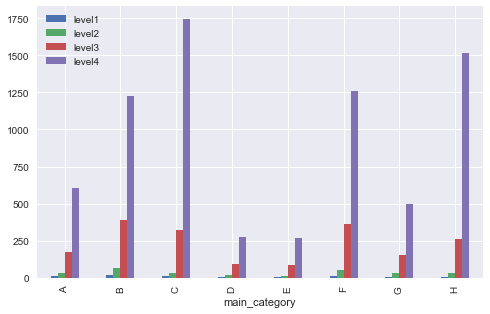

In [140]:
cols = ['level'+str(i) for i in range(1,max_depth)]
df.groupby('main_category')[cols].nunique().plot.bar()
df.groupby('main_category')[cols].nunique()

In [141]:
# Таблица  числа категорий на каждом уровне, сгрупировання по основной категории  и первому уровню(неинтересно)
cols = ['level'+str(i) for i in range(1,max_depth)]
#df.groupby(['main_category','level1'])[cols[1:]].nunique()

### Анализ числа изображений по всем уровням разбиения.

####   Общая статистика по числу изображений по категориям первого уровня

In [142]:
level1_img_stats =  df.groupby('level1')[['expected_img_count','real_img_count']].sum()
level1_img_stats.agg(['min','max','mean']).T

,min,max,mean
expected_img_count,1.0,48598.0,4161.048193
real_img_count,0.0,32183.0,2561.337349


#### Описание распредления числа изображений по категориям уровня 1

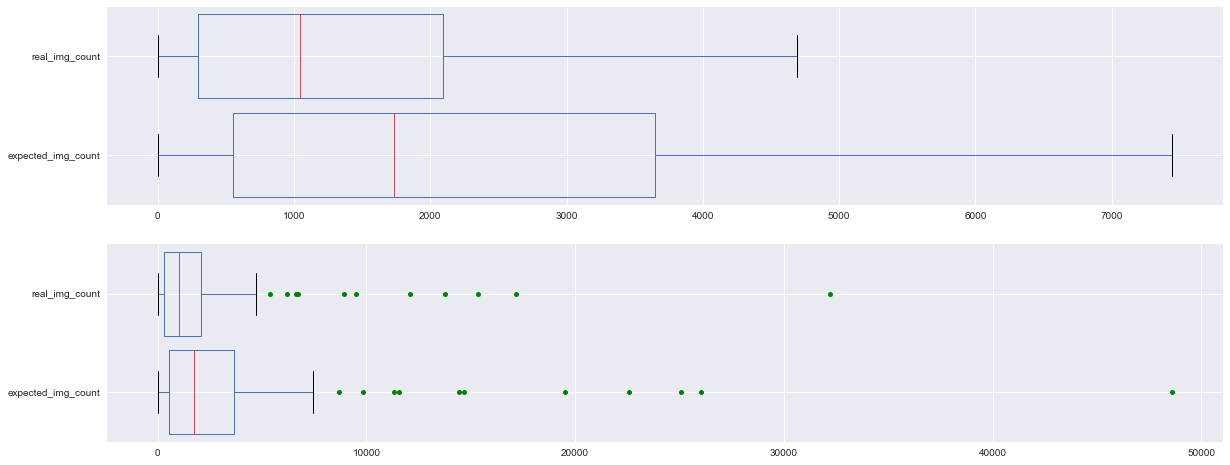

In [143]:
_, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,8))
#sns.boxplot(x='expected_img_count', data=level1_img_stats)
level1_img_stats.plot.box(widths=0.85,vert=False,showfliers=False, 
                          flierprops={'markersize':5, 'marker':'o', 'markerfacecolor':'green'},
                          ax=axes[0]
                         )
level1_img_stats.plot.box(widths=0.85,vert=False,showfliers=True, 
                          flierprops={'markersize':5, 'marker':'o', 'markerfacecolor':'green'},
                          ax=axes[1]
                         )

#### Выводы по диаграммам размаха:
***
##### 1) Ожидаемое число изображений по категориям:
* половина  категорий первого уровня будет содержать  не менее 1500 изображений
* четверть категорий первого уровня будет содержать от ~600 до 1500 изображений
* четверть категорий первого уровня будеть содержать  от ~ 1500 до 3500 изображений
***
##### 2) Собранное число изображений по категориям:
* половина  категорий первого уровня уже содержит  не менее 1000 изображений
* четверть категорий первого уровня уже содержит от ~300 до 1000 изображений
* четверть категорий первого уровня уже содержат  от ~ 1000 до 2200 изображений
****
##### Помимо этого среди категорий первого уровня есть категории, которые предположительно будет содержать около 40, 26, 25 и 22 тысяч изображений при среднем(см.выше) ожидаемом  числе в 4160 изображений на категорию(выбросы).

#### Топ 5 категорий первого уровня по реальному числу собранных изображений

In [144]:
level1_img_stats.sort_values('real_img_count', ascending=False).head(5)

,expected_img_count,real_img_count
level1,,
C07,48598,32183
H04,26010,17187
H01,25076,15337
F16,22578,13755
A61,19501,12096
